#  Data Analysis: Moral Foundations Theory
---
<img src="https://c1.staticflickr.com/7/6240/6261650491_0cd6c701bb_b.jpg" style="width: 500px; height: 275px;" />

### Professor Amy Tick

Moral Foundations Theory (MFT) hypothesizes that people's sensitivity to the foundations is different based on their political ideology: liberals are more sensitive to care and fairness, while conservatives are equally sensitive to all five. Here, we'll explore whether we can find evidence for MFT in the campaign speeches of 2016 United States presidential candidates. For our main analysis, we'll go through the data science process we learned in Day 1 to recreate a simplified version of the analysis done by Jesse Graham, Jonathan Haidt, and Brian A. Nosek in their 2009 paper ["Liberals and Conservatives Rely on Different Sets of Moral Foundations"](http://projectimplicit.net/nosek/papers/GHN2009.pdf). In part 3, we'll look at other NLP techniques that might be useful in applying this theory.

*Estimated Time: 50 minutes*

---

### Topics Covered
- Plotting data with MatPlotLib
- Interpreting graphs
- Textual analysis methods

### Table of Contents


1 - [Data Set and Test Statistic](#section 1)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 - [2016 Campaign Speeches](#subsection 1)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 - [Moral Foundations Dictionary](#subsection 2) <br>

2 - [Data Analysis](#section 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 - [Hypothesis](#subsection 3)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 - [Democrats](#subsection 4)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 - [Republicans](#subsection 5) <br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.4 - [Democrats vs Republicans](#subsection 6) <br>

3 - [Assignment: Analyze With Your Dictionary](#section 3)<br>


**Dependencies:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
from nltk.stem.snowball import SnowballStemmer
import os
import re

---
## Part 1: Speech Data and Foundations Dictionary  <a id='section 1'></a>

As data scientists starting a new analysis, we know we need to start with two things: some data and a question. In Part 1, we'll get familiar with our data set and determine a way to answer our question using the data.

### 2016 Campaign Speeches <a id='subsection 1'></a>

Our data set is the texts of speeches from the 2016 US presidential campaign. Run the cell below to load the data.

In [2]:
# load the data from csv files into a table. 

# reate an empty DataFrame
speeches = pd.DataFrame()

# The location of the files
path = '../mft_data/csv/'

# Cycle through the data files
for file in os.listdir(path=path):
    # Select campaign speech texts
    if file.endswith("c.csv"):
        if len(speeches) == 0:
            speeches = pd.read_csv(path + file)
        else:
            speeches = speeches.append(pd.read_csv(path + file))

# Reset the DataFrame index
speeches.reset_index(drop=True, inplace=True)

# Display the first 5 rows
speeches.head()

,Candidate,Party,Type,Date,Title,Speech
0,Jeb Bush,R,c,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...
1,Jeb Bush,R,c,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...
2,Jeb Bush,R,c,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...
3,Jeb Bush,R,c,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...
4,Jeb Bush,R,c,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...


---
Take a moment to look at this table. What information does it contain? What are the different columns? What does each row represent? How large is this table altogether? 

### Moral Foundations Dictionary <a id='subsection 2'></a>

In ["Liberals and Conservatives Rely on Different Sets of Moral Foundations"](http://projectimplicit.net/nosek/papers/GHN2009.pdf), one of the methods Graham, Haidt, and Nosek use to measure people's use of Moral Foundations Theory is to count how often they use words related to each foundation. This will be our test statistic for today. To calculate it, we'll need a dictionary of words related to each moral foundation. 

The dictionary we'll use today comes from a database called [WordNet](https://wordnet.princeton.edu), in which "nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept." By querying WordNet for semantically related words, it was possible to build a dictionary automatically using a Python program.

Run the cell below to load the dictionary and assign it to the variable 'mft_dict'.

In [3]:
# Run this cell to load the dictionary into the variable 'mft_dict'
with open('../mft_data/foundations_dict.json') as json_data:
    mft_dict = json.load(json_data)


We can see the keys of the dictionary using the .keys() function:

In [4]:
mft_dict.keys()

dict_keys(['authority/respect', 'care', 'fairness/proportionality', 'liberty', 'loyalty/ingroup', 'sanctity/purity'])

And we can look up the entries associated with a key by putting the key in brackets:

In [5]:
mft_dict['authority/respect']

['author',
 'authoris',
 'domin',
 'say-so',
 'assur',
 'confid',
 'sure',
 'agenc',
 'federal ag',
 'government ag',
 'bureau',
 'offic',
 'sanction',
 'respect',
 'regard',
 'esteem',
 'defer',
 'obedi',
 'valu',
 'honor',
 'honour',
 'abide bi',
 'observ']

Try looking up the entries for the other keys by filling in for '...' in the cell below.

In [6]:
# look up a key in mft_dict
...

There's something odd about some of the entries: they're not words! The entries in this dictionary have been **stemmed**, meaning they have been reduced to their smallest meaningful root. 

We can see why this is helpful with an example. Python can count the number of times a string can be found in another string using the string method 'count':

In [7]:
# Counts the number of times the second string appears in the first string
"Data science is the best major, says data scientist.".count('science')

1

It returns one match, for the second word. But, 'scientist' is very closely related to 'science', and many times we will want to match them both. A stem allows Python to find all words with a common root. Try running the count again with a stem that matches both 'science' and 'scientist'.

In [8]:
# Fill in the parenthesis with a stem that will match both 'science' and 'scientist'
"Data science is the best major, says data scientist.".count('...')

0

Another thing you might have noticed is that all the entries in our dictionary are lowercase. This could be a problem when we do our text analysis. Try counting the number of times 'rhetoric' appears in the example sentence.

In [9]:
# Fill in the parenthesis to count how often 'rhetoric' appears in the sentence
"Rhetoric major says back: NEVER argue with a rhetoric student.".count('...')

0

We can clearly see the word 'rhetoric' appears twice, but the count function only returns 1. That's because Python differentiates between capital and lowercase letters:

In [10]:
'r' is 'R'

False

To get around this, we can use the .lower() function, which changes all letters in the string to lowercase:

In [11]:
"Rhetoric major says back: NEVER argue with a rhetoric student.".lower()

'rhetoric major says back: never argue with a rhetoric student.'

In [12]:
my_dict = {'care': ['word1', 'word2'], 
           'loyalty': ['wlekf']}
my_dict

{'care': ['word1', 'word2'], 'loyalty': ['wlekf']}

Let's add a column to our 'speeches' table that contains the lowercase text of the speeches. The `clean_text` function lowers the case of the text in addition to implementing some of the text cleaning methods seen in Module 01, like removing the punctuation and splitting the text into individual words.

In [13]:
def clean_text(text):
    # remove punctuation using a regular expression (not covered in these modules)
    p = re.compile(r'[^\w\s]')
    no_punc = p.sub(' ', text)
    # convert to lowercase
    no_punc_lower = no_punc.lower()
    # split into individual words
    clean = no_punc_lower.split()
    return clean
    
speeches['clean_speech'] = [clean_text(s) for s in speeches['Speech']]

speeches.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech
0,Jeb Bush,R,c,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,..."
1,Jeb Bush,R,c,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y..."
2,Jeb Bush,R,c,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ..."
3,Jeb Bush,R,c,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ..."
4,Jeb Bush,R,c,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ..."


---
## Part 2: Exploratory Data Analysis <a id='section 2'></a>

Now that we have our speech data and our dictionary, we can start our analysis. First, we'll formally state our hypothesis. Then, to visualize the data we'll perform 3 steps:
1. Count the occurances of words from our dictionary in each speech
2. Calculate how often words from each category are used by each political party
3. Plot the percents on a bar graph

### Hypothesis <a id='subsection 3'></a>

An important part of data science is understanding the question you're trying to answer and formulating an appropriate hypothesis. The hypothesis must be testable given your data, and you must be able to say what kinds of results would support or refute your hypothesis. 

Today, our question asks whether the word use of 2016 presidential candidates aligns with Moral Foundations Theory.

Think about what you know about Moral Foundations Theory. If this data is consistent with the theory, what should our analysis show for Republican candidates? What about for Democratic candidates? Try sketching a possible graph for each political party, assuming that candidates' speech aligns with the theory.

### Filtering table rows

To examine the data for a particular political party, it is necessary to filter out rows of our table that correspond to speeches from the other party, something we can do with **Boolean indexing**.

A **Boolean** is a Python data type. There are exactly two: `True` and `False`. A Boolean expression is an expression that evaluates to `True` or `False`. Boolean expressions are often conditions on two variables; that is, they ask how one variable compares to another (e.g. is `a` greater than `b`? Does `a` equal `c`?).

In [14]:
# These are all Booleans
True

not False

6 > 0

"Ted Cruz" == "zodiac killer"

False

Note that to ask if something is equal to something else in Python, you use `==`. This is because the `=` sign is already used for variable assignement.

Filtering out DataFrame rows can be broken into two steps:
1. identify the correct feature column 
2. specify the desired condition for that column
3. index the Dataframe with that condition in square brackets

Here's an example of how to create a new table with only Bernie Sanders' speeches.

In [15]:
# find the column
speech_col = speeches['Candidate']

# specify the condition
sanders_condition =  speech_col == 'Bernie Sanders'

# index the original DataFrame by the condition
sanders_speeches = speeches[sanders_condition]
sanders_speeches.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech
272,Bernie Sanders,D,c,"April 30, 2015",Interview with Ed Schultz of MSNBC Regarding S...,Schultz: A gentleman who has appeared on the p...,"[schultz, a, gentleman, who, has, appeared, on..."
273,Bernie Sanders,D,c,"April 30, 2015",Interview with Wolf Blitzer of CNN Regarding S...,Blitzer: I want to move to politics right now ...,"[blitzer, i, want, to, move, to, politics, rig..."
274,Bernie Sanders,D,c,"April 30, 2015",Interview with Andrea Mitchell of MSNBC Regard...,Sanders (from video clip): I believe that in a...,"[sanders, from, video, clip, i, believe, that,..."
275,Bernie Sanders,D,c,"May 6, 2015","Interview with Chris Cuomo of CNN's ""New Day""","CUOMO: Senator Sanders, welcome to the race. G...","[cuomo, senator, sanders, welcome, to, the, ra..."
276,Bernie Sanders,D,c,"May 11, 2015",Interview with Andrea Mitchell of MSNBC,MITCHELL: Vermont Senator and Democratic presi...,"[mitchell, vermont, senator, and, democratic, ..."


### Democrats <a id='subsection 4'></a>

Let's start by looking at Democratic candidates. First, we need to make a table that only contains Democrats using boolean indexing.

In [16]:
# Filter out non-Democrat speeches
party_col = speeches['Party']

dem_cond = party_col == 'D'

democrats = speeches[dem_cond]

democrats.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech
8,Lincoln Chafee,D,c,"June 3, 2015",Remarks Announcing Candidacy for President at ...,"Thank you, Bob. Thank you, Bob and Mark, very ...","[thank, you, bob, thank, you, bob, and, mark, ..."
9,Lincoln Chafee,D,c,"July 17, 2015",Remarks at the Iowa Democrats Hall of Fame Din...,Congratulations to the Hall of Fame Inductees....,"[congratulations, to, the, hall, of, fame, ind..."
10,Lincoln Chafee,D,c,"October 23, 2015",Remarks Announcing the End of Presidential Cam...,Once again it is a pleasure to join so many De...,"[once, again, it, is, a, pleasure, to, join, s..."
13,Hillary Clinton,D,c,"January 20, 2007",Video Transcript: Presidential Exploratory Com...,HILLARY CLINTON: I announced today that I am f...,"[hillary, clinton, i, announced, today, that, ..."
14,Hillary Clinton,D,c,"January 22, 2007","Remarks in a ""Let the Conversation Begin Webcast""","SENATOR CLINTON: Hi, everyone, and welcome to ...","[senator, clinton, hi, everyone, and, welcome,..."


Our test statistic is the percent of words that correspond to a Moral Foundation in Democratic speeches- in other words, how often candidates use words related to a specific foundation. 

(Bonus question: why don't we just use the **number** of Moral Foundation words instead of the **percent** as our test statistic?)

To calculate the percent, we'll first need the total number of words in each speech.

In [17]:
# create a new column called 'total_words'
democrats['total_words'] = [len(speech) for speech in democrats['clean_speech']]
democrats.head()

C:\Users\keeley\AppData\Local\conda\conda\envs\dsmodules\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words
8,Lincoln Chafee,D,c,"June 3, 2015",Remarks Announcing Candidacy for President at ...,"Thank you, Bob. Thank you, Bob and Mark, very ...","[thank, you, bob, thank, you, bob, and, mark, ...",5512
9,Lincoln Chafee,D,c,"July 17, 2015",Remarks at the Iowa Democrats Hall of Fame Din...,Congratulations to the Hall of Fame Inductees....,"[congratulations, to, the, hall, of, fame, ind...",745
10,Lincoln Chafee,D,c,"October 23, 2015",Remarks Announcing the End of Presidential Cam...,Once again it is a pleasure to join so many De...,"[once, again, it, is, a, pleasure, to, join, s...",939
13,Hillary Clinton,D,c,"January 20, 2007",Video Transcript: Presidential Exploratory Com...,HILLARY CLINTON: I announced today that I am f...,"[hillary, clinton, i, announced, today, that, ...",349
14,Hillary Clinton,D,c,"January 22, 2007","Remarks in a ""Let the Conversation Begin Webcast""","SENATOR CLINTON: Hi, everyone, and welcome to ...","[senator, clinton, hi, everyone, and, welcome,...",5349


Next, we need to calculate the number of matches to entries in our dictionary for each speech and for each foundation. Some of the following code uses syntax not covered in these Modules. Don't sweat the details, as long as you can understand what the new columns mean.

In [18]:
# do the following code for each foundation
for key in mft_dict.keys():
    # create a new, empty column
    num_key_words = np.zeros(len(democrats))
    stems = mft_dict[key]
    
    # do the following code for each foundation word
    for stem in stems:
        # find synonym matches
        wd_count = np.array([sum([wd.startswith(stem) for wd in speech]) for speech in democrats['clean_speech']])
        # add the number of matches to the total
        num_key_words += wd_count
        
    # create a new column for each foundation with the percent of foundation words per speech
    democrats[key] = num_key_words / democrats['total_words'] * 100

democrats.head()

C:\Users\keeley\AppData\Local\conda\conda\envs\dsmodules\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words,authority/respect,care,fairness/proportionality,liberty,loyalty/ingroup,sanctity/purity
8,Lincoln Chafee,D,c,"June 3, 2015",Remarks Announcing Candidacy for President at ...,"Thank you, Bob. Thank you, Bob and Mark, very ...","[thank, you, bob, thank, you, bob, and, mark, ...",5512,0.199565,0.163280,0.199565,0.000000,0.199565,0.000000
9,Lincoln Chafee,D,c,"July 17, 2015",Remarks at the Iowa Democrats Hall of Fame Din...,Congratulations to the Hall of Fame Inductees....,"[congratulations, to, the, hall, of, fame, ind...",745,0.268456,0.134228,0.268456,0.000000,0.402685,0.000000
10,Lincoln Chafee,D,c,"October 23, 2015",Remarks Announcing the End of Presidential Cam...,Once again it is a pleasure to join so many De...,"[once, again, it, is, a, pleasure, to, join, s...",939,0.212993,0.106496,0.212993,0.106496,0.532481,0.000000
13,Hillary Clinton,D,c,"January 20, 2007",Video Transcript: Presidential Exploratory Com...,HILLARY CLINTON: I announced today that I am f...,"[hillary, clinton, i, announced, today, that, ...",349,0.286533,0.573066,0.000000,0.000000,0.859599,0.000000
14,Hillary Clinton,D,c,"January 22, 2007","Remarks in a ""Let the Conversation Begin Webcast""","SENATOR CLINTON: Hi, everyone, and welcome to ...","[senator, clinton, hi, everyone, and, welcome,...",5349,0.317816,0.261731,0.093475,0.000000,0.243036,0.056085


We have our percentages, but it's much easier to understand what's going on when the results are in graph form. Let's start by looking at the average percents for Democrats as a group. 


In [19]:
# select the foundations columns and calculate the mean percent for each
foundation_cols = list(mft_dict.keys())
avg_dem_stats = (democrats.loc[:, foundation_cols]
                 .apply(np.mean)
                 .to_frame('D_percent'))

avg_dem_stats

,D_percent
authority/respect,0.297649
care,0.275039
fairness/proportionality,0.167275
liberty,0.001454
loyalty/ingroup,0.236776
sanctity/purity,0.080898


Now, create a horizontal bar plot by calling the `.plot.barh()` method on `avg_dem_stats`. 

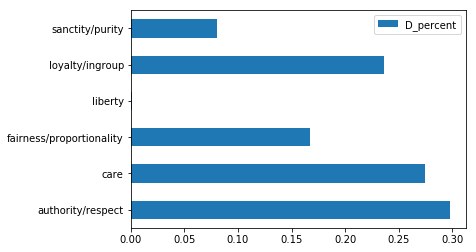

In [20]:
avg_dem_stats.plot.barh()

Take a look at this graph. What does it show? Does it support our hypothesis?

We can also look at how different candidates used different foundations:

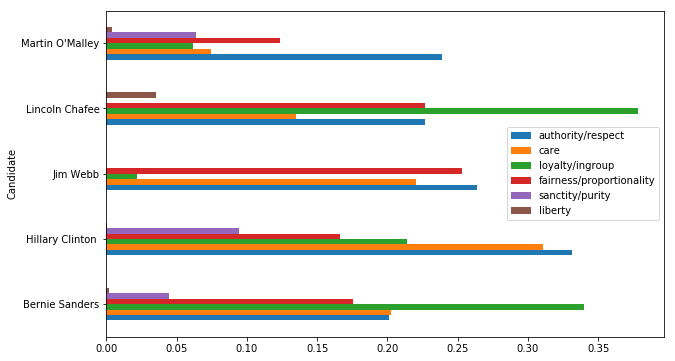

In [21]:
dem_indivs = (democrats.loc[:, ['Candidate', 'authority/respect', 'care', 'loyalty/ingroup', 'fairness/proportionality',
                               'sanctity/purity', 'liberty']]
             .groupby(['Candidate'])
             .mean())
dem_indivs.plot.barh(figsize=(10, 6))

### Republicans <a id='subsection 5'></a>

Now, let's repeat the process for Republicans. Replace the ellipses with the correct code to select only Republican speeches, then run the cell to create the table. 

(Hint: look back at how we made the 'democrats' table to see how to fill in the ellipses)

In [22]:
# Filter out non-Republican speeches

# select 'Party' column from 'speeches'
party_col = ...

# create a condition (boolean expression) that checks if a party is Republican
republican_cond = ...

# index `speeches` using `republican_cond
republicans = speeches

# uncomment the next line to show the first 5 rows of the `republican` DataFrame
#republicans.head()

Next, we need to calculate our test statistic for Republicans. Fill in the ellipses in the cell below with the correct code to create a table with the statistics. Once again, look at how we made this table for Democrats, and think about how you need to change the code for Republicans.

In [23]:
# Calculate the proportions for Republican speeches
republicans['total_words'] = [len(speech) for speech in republicans['Speech']]

# uncomment the next line to show the DataFrame with the total word counts
#republicans.head()

Then, calculate foundation synonym percents:

In [24]:
# do the following code for each foundation
for key in mft_dict.keys():
    # create a new, empty column
    num_key_words = np.zeros(len(republicans))
    stems = mft_dict[key]
    
    # do the following code for each foundation word
    for stem in stems:
        # find synonym matches
        wd_count = np.array([sum([wd.startswith(stem) for wd in speech]) for speech in republicans['clean_speech']])
        # add the number of matches to the total
        num_key_words += wd_count
        
    # create a new column for each foundation with the percent of foundation words per speech
    republicans[key] = num_key_words / republicans['total_words'] * 100

republicans.head()

,Candidate,Party,Type,Date,Title,Speech,clean_speech,total_words,authority/respect,care,fairness/proportionality,liberty,loyalty/ingroup,sanctity/purity
0,Jeb Bush,R,c,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,"[thank, you, all, very, much, i, always, feel,...",12383,0.032302,0.040378,0.056529,0.0,0.056529,0.016151
1,Jeb Bush,R,c,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,"[thank, you, all, very, much, i, appreciate, y...",14457,0.055337,0.013834,0.048419,0.0,0.013834,0.013834
2,Jeb Bush,R,c,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,"[thank, you, very, much, it, s, good, to, be, ...",21283,0.056383,0.023493,0.028192,0.0,0.009397,0.014096
3,Jeb Bush,R,c,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,"[thank, you, very, much, i, appreciate, your, ...",10049,0.029854,0.009951,0.029854,0.0,0.000000,0.000000
4,Jeb Bush,R,c,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,"[thank, you, it, s, great, to, be, in, tampa, ...",14189,0.049334,0.021143,0.007048,0.0,0.021143,0.021143


Then, calculate the averages.

In [25]:
# select the foundations columns and calculate the mean percent for each
foundation_cols = list(mft_dict.keys())
avg_rep_stats = (republicans.loc[:, foundation_cols]
                 .apply(np.mean)
                 .to_frame('R_percent'))

avg_rep_stats 

,R_percent
authority/respect,0.055909
care,0.042317
fairness/proportionality,0.031424
liberty,0.000267
loyalty/ingroup,0.037831
sanctity/purity,0.014723


Finally, create a bar plot of `avg_rep_stats` using the `.plot.barh()` method.

In [26]:
# your code here


Does this graph support our hypothesis? 

Finally, let's look at individual Republican candidate averages.

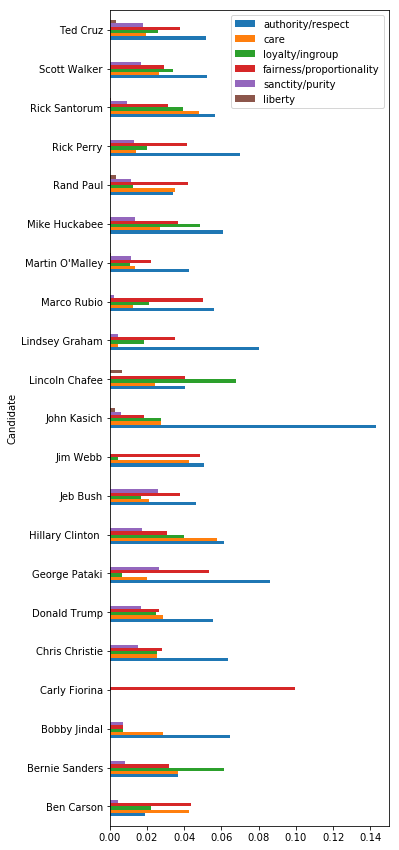

In [27]:
rep_indivs = (republicans.loc[:, ['Candidate', 'authority/respect', 'care', 'loyalty/ingroup', 'fairness/proportionality',
                               'sanctity/purity', 'liberty']]
             .groupby(['Candidate'])
             .mean())
rep_indivs.plot.barh(figsize=(5, 15))

### Democrats vs Republicans <a id='subsection 6'></a>

Comparing two groups becomes much easier when they are plotted on the same graph. 

First, combine `avg_dem_stats` and `avg_rep_stats` into one DataFrame with the `join` function. `join` is called on one table using `.join()`, takes the other table as its argument (in the parentheses), and returns a table with the indices matched. 

Here's an example of a simple join:

In [28]:
peanut_butter = pd.DataFrame(data=[2.99, 3.49], index = ['Trader Joes', 'Safeway'], columns=['pb_price'])
peanut_butter

,pb_price
Trader Joes,2.99
Safeway,3.49


In [29]:
jelly = pd.DataFrame(data=[4.99, 3.59], index = ['Trader Joes', 'Safeway'], columns=['jelly_price'])
jelly

,jelly_price
Trader Joes,4.99
Safeway,3.59


In [30]:
jelly.join(peanut_butter)

,jelly_price,pb_price
Trader Joes,4.99,2.99
Safeway,3.59,3.49


Now, write the code to join `'avg_dem_stats` with `avg_rep_stats`.

In [31]:
# fill in the ellipses with your code
all_avg_stats = ...
all_avg_stats

Ellipsis

Then, make a horiztonal bar plot for `all_avg_stats'.

In [32]:
# your code here


---
## Assignment: Run Analysis With Your Dictionary  <a id='section 3'></a>

One of the advantages of coding is how easy it is to repeat one method of analysis with different parameters. Run the cell below to load the dictionary you compiled into the `mft_dict` variable 

(Note that Section 1 sets `mft_dict` to the Wordnet dictionary. By running the next cell, you will overwrite it and set it to the dictionary you made. It's possible to reset it to the Wordnet dictionary by re-running the cell in [Section 1.2](#subsection 2).)

After you reset `mft_dict`, return to [Section 2](#section 2) and run the code cells to regenerate the graphs using your dictionary. You should be able to answer the following questions:

* What does each graph show?
* How are these graphs different from the ones made using the Wordnet dictionary?
* Do these graphs support Moral Foundations Theory?

In [33]:
# Tip: if you're working on this assignment after class, remember to import your 
# dependencies by running the very first code cell in this module

# Load your dictionary into the mft_dict variable
with open('../mft_data/my_dict.json') as json_data:
    mft_dict = json.load(json_data)

# Stem the words in your dictionary (this will help you get more matches)
stemmer = SnowballStemmer('english')

for foundation in mft_dict.keys():
    curr_words = mft_dict[foundation]
    stemmed_words = [stemmer.stem(word) for word in curr_words]
    mft_dict[foundation] = stemmed_words

---

## Bibliography

* Election documents scraped from http://www.presidency.ucsb.edu/2016_election.php
* Graham, J., Haidt, J., & Nosek, B. A. (2009). Liberals and conservatives rely on different sets of moral foundations. Journal of personality and social psychology, 96(5), 1029. http://projectimplicit.net/nosek/papers/GHN2009.pdf, October 9 2017.

---
Notebook developed by: Keeley Takimoto, Sean Seungwoo Son, Sujude Dalieh

Data Science Modules: http://data.berkeley.edu/education/modules
